In [1]:
! pip install loguru

In [2]:
! pip install numpy pandas matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib import rc
import random
import math
import time
import copy
from queue import PriorityQueue
from dataclasses import dataclass, field
from typing import Optional, Any
import warnings
from loguru import logger
from collections.abc import Callable
from functools import lru_cache

warnings.filterwarnings('ignore')

rc('animation', html='jshtml')

In [4]:
from utils import Environment, Manipulator, ManipulatorState, factor_by_2pi

In [5]:
class RRTCore:
    def __init__(
        self, 
        manipulator: Manipulator, 
        environment: Environment, 
        goal_state: ManipulatorState, 
        max_iterations: int = 5000,
        step_size: float = 0.2, 
        goal_bias: float = 0.1,    
    ):
        self.manipulator = manipulator
        self.environment = environment
        self.goal_state = goal_state
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.goal_bias = goal_bias

        self.metrics: dict[str, float | bool] = {
            "n_iterations": 0,
            "n_nodes": 0,
            "len_path": 0,
            "time": 0,
            "is_success": False,
        }

        self.start_state = manipulator.state.copy()
        if self.environment.check_manipulator_collision(self.manipulator, self.start_state):
            raise ValueError("Коллизия начального состояния")
        
        if self.environment.check_manipulator_collision(self.manipulator, self.goal_state):
            raise ValueError("Коллизия целевого состояния")
        

    def _random_state(self) -> ManipulatorState:
        """Генерация случайного состояния"""
        if random.random() < self.goal_bias:
            return self.goal_state.copy()
        
        angles: list[float] = []
        for _ in range(self.manipulator.num_joints):
            angles.append(random.uniform(-np.pi, np.pi))
        
        return ManipulatorState(angles=angles, position=self.start_state.position)
    
    def _nearest_neighbor(
        self, 
        state: ManipulatorState, 
        tree_nodes: list[ManipulatorState],
    ) -> tuple[int, ManipulatorState]:
        """Поиск ближайшего узла в дереве к заданному состоянию"""
        min_dist = float('inf')
        nearest_idx = 0
        nearest_state = tree_nodes[0]
        
        for i, node in enumerate(tree_nodes):
            dist = 0
            for a1, a2 in zip(state.angles, node.angles):
                diff = abs(a1 - a2)
                diff = min(diff, 2 * np.pi - diff)
                dist += diff ** 2
            
            if dist < min_dist:
                min_dist = dist
                nearest_idx = i
                nearest_state = node
        
        return nearest_idx, nearest_state
    
    def _steer(
        self, 
        from_state: ManipulatorState, 
        to_state: ManipulatorState,
    ) -> ManipulatorState:
        """
        Движение от from_state в направлении to_state на расстояние step_size
        """
        delta_angles: list[float] = []
        for a1, a2 in zip(to_state.angles, from_state.angles):
            diff = a2 - a1  # a2 - это угол в from_state, a1 - в to_state
            delta = factor_by_2pi(diff)
            delta_angles.append(-delta)  # Двигаемся в противоположном направлении
        
        # Нормализуем вектор разности
        delta_norm = np.sqrt(sum(d**2 for d in delta_angles))
        if delta_norm == 0:
            return from_state.copy()
        
        # Ограничение шага
        scale = min(self.step_size / delta_norm, 1.0)
        
        # Создаем новое состояние
        new_angles: list[float] = []
        for from_angle, delta in zip(from_state.angles, delta_angles):
            new_angle = from_angle + delta * scale
            new_angles.append(factor_by_2pi(new_angle))
        
        return ManipulatorState(angles=new_angles, position=from_state.position)
    
    def _is_path_free(
        self, 
        from_state: ManipulatorState, 
        to_state: ManipulatorState, 
        num_checks: int = 10,
    ) -> bool:
        """
        Args:
            from_state: Начальное состояние
            to_state: Конечное состояние
            num_checks: Количество промежуточных проверок
        
        Returns:
            True если путь свободен от столкновений
        """
        # Проверяем промежуточные состояния
        for i in range(num_checks + 1):
            t = i / num_checks
            
            # Интерполируем углы
            interpolated_angles: list[float] = []
            for a1, a2 in zip(from_state.angles, to_state.angles):
                diff = a2 - a1
                interp_angle = a1 + t * factor_by_2pi(diff)
                interpolated_angles.append(interp_angle)
            
            interp_state = ManipulatorState(
                angles=interpolated_angles, 
                position=from_state.position
            )
            
            # Проверяем столкновение
            if self.environment.check_manipulator_collision(self.manipulator, interp_state):
                return False
        
        return True

In [6]:
class RRTPlanner(RRTCore):    
    def __init__(
        self, 
        manipulator: Manipulator, 
        environment: Environment, 
        goal_state: ManipulatorState, 
        max_iterations: int = 5000,
        step_size: float = 0.2, 
        goal_bias: float = 0.1,
    ):
        """        
        Args:
            manipulator: Манипулятор
            environment: Среда с препятствиями
            goal_state: Целевое состояние
            max_iterations: Максимальное количество итераций
            step_size: Размер шага при расширении дерева
            goal_bias: Вероятность выбора цели в качестве случайной точки
        """
        super().__init__(
            manipulator, 
            environment, 
            goal_state, 
            max_iterations,
            step_size, 
            goal_bias,
        )
        self.tree_nodes = [self.start_state]
        self.tree_parents = {0: -1}
        # parent[index] = parent_index, -1 для корня
        
        self.node_features = []  # Будем хранить углы как признаки для поиска
    
    def plan(self) -> tuple[bool, list[ManipulatorState]]:
        """
        Выполнение планирования траектории
        
        Returns:
            (успех | неуспех, путь)
        """
        logger.info("RRT")
        start_time = time.time()
        
        for iteration in range(self.max_iterations):
            random_state = self._random_state()
            
            nearest_idx, nearest_state = self._nearest_neighbor(random_state, self.tree_nodes)
            
            new_state = self._steer(nearest_state, random_state)
            
            if self._is_path_free(nearest_state, new_state):
                if not self.environment.check_manipulator_collision(self.manipulator, new_state):
                    new_idx = len(self.tree_nodes)
                    self.tree_nodes.append(new_state)
                    self.tree_parents[new_idx] = nearest_idx
                    
                    if self._is_goal_reached(new_state):
                        logger.info(f"Итерация: {iteration}. Манипулятор в целевом состоянии.")
                        
                        path = self._reconstruct_path(new_idx)
                        end_time = time.time()

                        # заполняем метрики
                        self.metrics["n_iterations"] = iteration
                        self.metrics["n_nodes"] = len(self.tree_nodes)
                        self.metrics["len_path"] = len(path)
                        self.metrics["time"] = end_time - start_time
                        self.metrics["is_success"] = True
                        #

                        logger.info(f"Алгоритм работал: {end_time - start_time:.2f} (секунд)")
                        logger.info(f"Длина пути: {len(path)} (состояний)")
                        return True, path
            
            if iteration % 500 == 0 and iteration > 0:
                #  каждые 500 итераций логгируемся
                logger.info(f"{iteration}/{self.max_iterations} итерация, количество нод: {len(self.tree_nodes)}")
        
        end_time = time.time()
        # заполняем метрики
        self.metrics["n_iterations"] = self.max_iterations
        self.metrics["n_nodes"] = len(self.tree_nodes)
        self.metrics["len_path"] = 0
        self.metrics["time"] = end_time - start_time
        self.metrics["is_success"] = False
        #
        logger.info(f"Алгоритм не нашел решения. Запуск занял: {self.max_iterations} (итераций)")
        logger.info(f"Время выполнения: {end_time - start_time:.2f} (секунд)")
        return False, []
    
    def _is_goal_reached(
        self, 
        state: ManipulatorState, 
        tolerance: float = 0.2,
    ) -> bool:
        """Проверка, достигнута ли цель"""
        # Вычисляем расстояние до цели
        dist = 0
        for a1, a2 in zip(state.angles, self.goal_state.angles):
            diff = abs(a1 - a2)
            diff = min(diff, 2*np.pi - diff)
            dist += diff**2
        
        return np.sqrt(dist) < tolerance
    
    def _reconstruct_path(
        self, 
        goal_idx: int,
    ) -> list[ManipulatorState]:
        """Восстановление пути от цели к началу"""
        path: list[ManipulatorState] = []
        current_idx = goal_idx
        
        while current_idx != -1:
            path.append(self.tree_nodes[current_idx])
            current_idx = self.tree_parents[current_idx]
        
        # Переворачиваем путь (от начала к цели)
        path.reverse()
        return path

In [7]:
class RRTConnectPlanner(RRTCore):    
    def __init__(
        self, 
        manipulator: Manipulator, 
        environment: Environment, 
        goal_state: ManipulatorState, 
        max_iterations: int = 3000,
        step_size: float = 0.2, 
        goal_bias: float = 0.1,
    ):
        """
        Args:
            manipulator: Манипулятор
            environment: Среда с препятствиями
            goal_state: Целевое состояние
            max_iterations: Максимальное количество итераций
            step_size: Размер шага при расширении дерева
            goal_bias: Вероятность выбора цели в качестве случайной точки
        """
        super().__init__(
            manipulator, 
            environment, 
            goal_state, 
            max_iterations,
            step_size, 
            goal_bias,
        )
        # Инициализируем два дерева: от начала и от цели
        self.tree_a_nodes = [self.start_state]
        self.tree_a_parents = {0: -1}
        
        self.tree_b_nodes = [self.goal_state]
        self.tree_b_parents = {0: -1}
        
        # Для соединения деревьев
        self.connection_state = None
        self.connection_tree = 'a'  # Из какого дерева было соединение
        
    def _extend(
        self, 
        tree_nodes: list[ManipulatorState], 
        tree_parents: dict[int, int], 
        random_state: ManipulatorState
    ) -> tuple[str, int]:
        """
        Расширение дерева в направлении случайного состояния
        
        Returns:
            (статус, индекс нового узла)
            статус: 'trapped' - не удалось расширить,
                   'advanced' - удалось расширить,
                   'reached' - достигли случайного состояния
        """
        nearest_idx, nearest_state = self._nearest_neighbor(random_state, tree_nodes)
        new_state = self._steer(nearest_state, random_state)
        
        if self._is_path_free(nearest_state, new_state):
            if not self.environment.check_manipulator_collision(self.manipulator, new_state):
                new_idx = len(tree_nodes)
                tree_nodes.append(new_state)
                tree_parents[new_idx] = nearest_idx
                
                dist = 0
                for a1, a2 in zip(new_state.angles, random_state.angles):
                    diff = abs(a1 - a2)
                    diff = min(diff, 2*np.pi - diff)
                    dist += diff**2
                
                if np.sqrt(dist) < 0.05:  # Достигли случайного состояния
                    return 'reached', new_idx
                else:
                    return 'advanced', new_idx
        
        return 'trapped', -1
    
    def _connect(self, tree_nodes: list[ManipulatorState], tree_parents: dict[int, int], 
                target_state: ManipulatorState) -> tuple[str, int]:
        """
        Попытка соединения дерева с целевым состоянием
        
        Returns:
            (статус, индекс последнего добавленного узла)
        """
        status = 'advanced'
        last_idx = -1
        
        while status == 'advanced':
            status, new_idx = self._extend(tree_nodes, tree_parents, target_state)
            if status == 'advanced':
                last_idx = new_idx
            elif status == 'reached':
                last_idx = new_idx
                return 'reached', last_idx
        
        return status, last_idx
    
    def plan(self) -> tuple[bool, list[ManipulatorState]]:
        """Выполнение планирования траектории с помощью RRT-Connect"""
        logger.info("RRT-Connect")
        start_time = time.time()
        
        for iteration in range(self.max_iterations):
            random_state = self._random_state()
            
            # Пытаемся расширить дерево A в направлении случайного состояния
            status_a, new_idx_a = self._extend(self.tree_a_nodes, self.tree_a_parents, random_state)
            
            if status_a != 'trapped':
                # Пытаемся соединить дерево B с новым состоянием
                status_b, new_idx_b = self._connect(self.tree_b_nodes, self.tree_b_parents, self.tree_a_nodes[new_idx_a])
                
                if status_b == 'reached':
                    logger.info(f"Итерация: {iteration}. Деревья экспансии соеденины.")
                    
                    path = self._reconstruct_path(new_idx_a, new_idx_b)
                    end_time = time.time()

                    # заполняем метрики
                    self.metrics["n_iterations"] = iteration
                    self.metrics["n_nodes"] = (len(self.tree_a_nodes), len(self.tree_b_nodes))
                    self.metrics["len_path"] = len(path)
                    self.metrics["time"] = end_time - start_time
                    self.metrics["is_success"] = True
                    #

                    logger.info(f"Алгоритм работал: {end_time - start_time:.2f} (секунд)")
                    logger.info(f"Длина пути: {len(path)} (состояний)")
                    return True, path
            
            # Меняем деревья местами для следующей итерации
            self.tree_a_nodes, self.tree_b_nodes = self.tree_b_nodes, self.tree_a_nodes
            self.tree_a_parents, self.tree_b_parents = self.tree_b_parents, self.tree_a_parents
            
            if iteration % 500 == 0 and iteration > 0:
                logger.info(f"{iteration}/{self.max_iterations} итерация, количество нод: {len(self.tree_a_nodes)} (дерево из инициального состояния) и {len(self.tree_b_nodes)} (дерево из терминальног состояния)")
        
        end_time = time.time()
        # заполняем метрики
        self.metrics["n_iterations"] = self.max_iterations
        self.metrics["n_nodes"] = (len(self.tree_a_nodes), len(self.tree_b_nodes))
        self.metrics["len_path"] = 0
        self.metrics["time"] = end_time - start_time
        self.metrics["is_success"] = False
        
        logger.info(f"Алгоритм не нашел решения. Запуск занял: {self.max_iterations} (итераций)")
        logger.info(f"Время выполнения: {end_time - start_time:.2f} (секунд)")
        return False, []
    
    def _reconstruct_path(self, idx_a: int, idx_b: int) -> list[ManipulatorState]:
        """Восстановление пути при соединении двух деревьев"""
        # Путь от начала до точки соединения в дереве A
        path_a: list[ManipulatorState] = []
        current_idx = idx_a
        while current_idx != -1:
            path_a.append(self.tree_a_nodes[current_idx])
            current_idx = self.tree_a_parents[current_idx]
        path_a.reverse()  # Теперь от начала к точке соединения
        
        # Путь от точки соединения до цели в дереве B
        path_b: list[ManipulatorState] = []
        current_idx = idx_b
        while current_idx != -1:
            path_b.append(self.tree_b_nodes[current_idx])
            current_idx = self.tree_b_parents[current_idx]
        # path_b уже от точки соединения к цели
        
        # Объединяем пути
        full_path = path_a + path_b[1:]  # Исключаем точку соединения, т.к. она уже есть в path_a
        return full_path

In [8]:
class Visualizer:
    """Класс для визуализации манипулятора, среды и планирования"""
    
    def __init__(
        self, 
        environment: Environment, 
        manipulator: Manipulator,
        path_to_upload: str,
    ):
        self.environment = environment
        self.manipulator = manipulator
        self.fig = None
        self.ax = None
        self.path_to_upload = path_to_upload
        
    def setup_plot(self):
        """Настройка графика"""
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.ax.set_xlim(0, self.environment.width)
        self.ax.set_ylim(0, self.environment.height)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_title('Планирование траектории манипулятора')
    
    def draw_environment(self):
        """Отрисовка среды с препятствиями"""
        for i in range(self.environment.grid_width):
            for j in range(self.environment.grid_height):
                if self.environment.obstacle_grid[j, i]:
                    x = i * self.environment.grid_resolution
                    y = j * self.environment.grid_resolution
                    rect = patches.Rectangle(
                        (x, y), self.environment.grid_resolution, 
                        self.environment.grid_resolution,
                        linewidth=0.5, edgecolor='darkred', 
                        facecolor='red', alpha=0.5
                    )
                    self.ax.add_patch(rect)
        
        for obstacle in self.environment.obstacles:
            if obstacle['type'] == 'rectangle':
                rect = patches.Rectangle(
                    (obstacle['x'], obstacle['y']), 
                    obstacle['width'], obstacle['height'],
                    linewidth=1, edgecolor='darkred', 
                    facecolor='red', alpha=0.7
                )
                self.ax.add_patch(rect)
            elif obstacle['type'] == 'circle':
                circle = patches.Circle(
                    (obstacle['x'], obstacle['y']), 
                    obstacle['radius'],
                    linewidth=1, edgecolor='darkred', 
                    facecolor='red', alpha=0.7
                )
                self.ax.add_patch(circle)
    
    def draw_manipulator(
        self, 
        state: ManipulatorState, 
        color: str = 'gray', 
        alpha: float = 1, 
        show_joints: bool = True,
    ):
        """Отрисовка манипулятора в заданном состоянии"""
        # Получаем позиции суставов
        positions = self.manipulator.get_joint_positions(state)
        
        # Рисуем звенья
        for i in range(len(positions) - 1):
            start = positions[i]
            end = positions[i+1]
            
            # Рисуем линию звена
            self.ax.plot([start[0], end[0]], [start[1], end[1]], 
                        color=color, linewidth=self.manipulator.link_widths[i]*10, 
                        alpha=alpha, solid_capstyle='round')
        
        # Рисуем суставы
        if show_joints:
            for i, pos in enumerate(positions):
                if i == 0:  # Основание
                    joint_color = 'black'
                    size = 50
                elif i == len(positions) - 1:  # конечный узел манипулятора
                    joint_color = 'yellow'
                    size = 60
                else:  # Промежуточные суставы
                    joint_color = 'gray'
                    size = 40
                
                self.ax.scatter(pos[0], pos[1], s=size, c=joint_color, 
                               edgecolors='black', linewidth=1, zorder=5, alpha=alpha)
    
    def draw_tree(
        self, 
        tree_nodes: list[ManipulatorState], 
        tree_parents: dict[int, int], 
        color: str = 'gray', 
        alpha: float = 0.3, 
        draw_nodes: bool = False,
    ):
        """Отрисовка дерева RRT"""
        for idx, parent_idx in tree_parents.items():
            if parent_idx != -1:
                # Получаем позиции концевиков
                node_state = tree_nodes[idx]
                parent_state = tree_nodes[parent_idx]
                
                node_pos = self.manipulator.get_end_effector_position(node_state)
                parent_pos = self.manipulator.get_end_effector_position(parent_state)
                
                # Рисуем ребро дерева
                self.ax.plot([parent_pos[0], node_pos[0]], 
                           [parent_pos[1], node_pos[1]], 
                           color=color, linewidth=1, alpha=alpha)
        
        if draw_nodes:
            for node_state in tree_nodes:
                pos = self.manipulator.get_end_effector_position(node_state)
                self.ax.scatter(pos[0], pos[1], s=10, c=color, alpha=alpha*0.5)
    
    def draw_path(
        self, 
        path: list[ManipulatorState], 
        color: str = 'blue', 
        linewidth: float = 2, 
        alpha: float = 0.7,
    ):
        """Отрисовка пути"""
        if len(path) < 2:
            return
        
        # Рисуем траекторию концевика
        ee_positions = []
        for state in path:
            ee_pos = self.manipulator.get_end_effector_position(state)
            ee_positions.append(ee_pos)
        
        # Соединяем точки
        for i in range(len(ee_positions) - 1):
            self.ax.plot([ee_positions[i][0], ee_positions[i+1][0]], 
                       [ee_positions[i][1], ee_positions[i+1][1]], 
                       color=color, linewidth=linewidth, alpha=alpha, linestyle='-')
        
        # Рисуем точки пути
        for i, pos in enumerate(ee_positions):
            if i == 0:  # Начало
                marker_color = 'yellow'
                size = 80
            elif i == len(ee_positions) - 1:  # Конец
                marker_color = 'red'
                size = 80
            else:  # Промежуточные точки
                marker_color = color
                size = 30
            
            self.ax.scatter(pos[0], pos[1], s=size, c=marker_color, 
                           edgecolors='black', linewidth=1, zorder=10, alpha=alpha)
    
    def visualize_planning(
        self,
        planner: RRTPlanner | RRTConnectPlanner, 
        path: list[ManipulatorState], 
        show_tree: bool = True,
    ):
        """Визуализация результата планирования"""
        self.setup_plot()
        self.draw_environment()
        
        # Отрисовываем дерево (если есть)
        if show_tree and hasattr(planner, 'tree_nodes') and hasattr(planner, 'tree_parents'):
            self.draw_tree(planner.tree_nodes, planner.tree_parents, color='gray', alpha=0.3)
        
        # Отрисовываем путь
        self.draw_path(path, color='green', linewidth=3, alpha=0.8)
        
        # Отрисовываем начальное положение
        self.draw_manipulator(self.manipulator.state, color='gray', alpha=0.7)
        
        # Отрисовываем конечное положение
        self.draw_manipulator(planner.goal_state, color='red', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    def animate_path(
        self, 
        path: list[ManipulatorState], 
        interval: int = 100,
    ):
        """Анимация движения манипулятора по найденному пути"""
        self.setup_plot()
        self.draw_environment()
        
        # Рисуем путь концевика
        self.draw_path(path, color='green', linewidth=2, alpha=0.5)
        
        # Создаем элементы для анимации
        manipulator_lines = []
        for i in range(self.manipulator.num_joints):
            line, = self.ax.plot([], [], color='blue', 
                               linewidth=self.manipulator.link_widths[i]*10, 
                               solid_capstyle='round')
            manipulator_lines.append(line)
        
        joints_scatter = self.ax.scatter([], [], s=50, c='blue', 
                                        edgecolors='black', linewidth=1, zorder=5)
        base_scatter = self.ax.scatter([], [], s=70, c='green', 
                                      edgecolors='black', linewidth=1, zorder=5)
        ee_scatter = self.ax.scatter([], [], s=80, c='orange', 
                                    edgecolors='black', linewidth=1, zorder=5)
        
        def init():
            for line in manipulator_lines:
                line.set_data([], [])
            joints_scatter.set_offsets(np.empty((0, 2)))
            base_scatter.set_offsets(np.empty((0, 2)))
            ee_scatter.set_offsets(np.empty((0, 2)))
            return manipulator_lines + [joints_scatter, base_scatter, ee_scatter]
        
        # Функция обновления кадра
        def update(frame) -> list:
            state = path[frame]
            positions = self.manipulator.get_joint_positions(state)
            
            # Обновляем линии звеньев
            for i in range(self.manipulator.num_joints):
                manipulator_lines[i].set_data([positions[i][0], positions[i+1][0]], 
                                            [positions[i][1], positions[i+1][1]])
            
            # Обновляем точки суставов (исключая основание и концевик)
            if len(positions) > 2:
                joint_positions = np.array(positions[1:-1])
                joints_scatter.set_offsets(joint_positions)
            else:
                joints_scatter.set_offsets(np.empty((0, 2)))
            
            # Обновляем основание и концевик
            base_scatter.set_offsets([positions[0]])
            ee_scatter.set_offsets([positions[-1]])
            
            # Обновляем заголовок
            self.ax.set_title(f'Движение манипулятора: кадр {frame+1}/{len(path)}')
            
            return manipulator_lines + [joints_scatter, base_scatter, ee_scatter]
        
        # Создаем анимацию
        anim = animation.FuncAnimation(
            self.fig, 
            update, 
            frames=len(path),
            init_func=init, 
            interval=interval, 
            blit=True,
        )
        
        plt.tight_layout()

        anim.save(self.path_to_upload + ".gif", writer='pillow')
        plt.close(self.fig)
        
        return anim

----

Начальное состояние манипулятора:[*]Количество звеньев: 4[*]Позиция основания: [2. 2.][*]Углы суставов: [0.0, 0.7853979999999998, -0.5235989999999999, 0.0][*]Позиция концевика: [10.76088046  4.57889735]


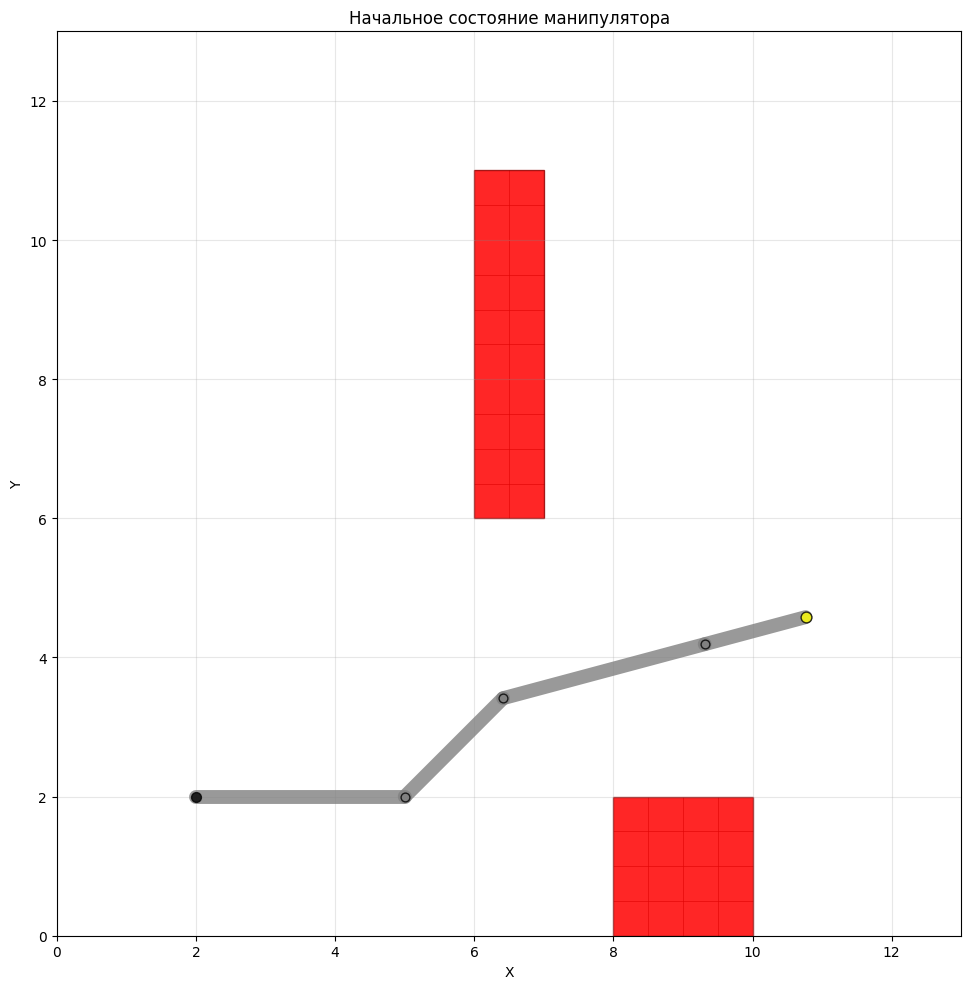

In [9]:
from runs.cfgs.run_1 import env as env_1, manipulator as manipulator_1, goal_angles as goal_angles_1
from runs.cfgs.run_2 import env as env_2, manipulator as manipulator_2, goal_angles as goal_angles_2
from runs.cfgs.run_3 import env as env_3, manipulator as manipulator_3, goal_angles as goal_angles_3
from runs.cfgs.run_4 import env as env_4, manipulator as manipulator_4, goal_angles as goal_angles_4

tests = {
    1: {"env": env_1, "manipulator": manipulator_1, "goal_angles": goal_angles_1},
    2: {"env": env_2, "manipulator": manipulator_2, "goal_angles": goal_angles_2},
    3: {"env": env_3, "manipulator": manipulator_3, "goal_angles": goal_angles_3},
    4: {"env": env_4, "manipulator": manipulator_4, "goal_angles": goal_angles_4},

}


N = 3
env = tests[N]["env"]
manipulator = tests[N]["manipulator"]
out_dir = f"runs/outs/test_{N}_try{np.random.randint(1, 1_000_000)}"
goal_angles = tests[N]["goal_angles"]
goal_state = ManipulatorState(angles=goal_angles, position=manipulator.base_position)

viz = Visualizer(env, manipulator, path_to_upload=out_dir)

print(
    "Начальное состояние манипулятора:"
    f"[*]Количество звеньев: {manipulator.num_joints}"
    f"[*]Позиция основания: {manipulator.base_position}"
    f"[*]Углы суставов: {manipulator.state.angles}"
    f"[*]Позиция концевика: {manipulator.get_end_effector_position()}"
)

viz.setup_plot()
viz.draw_environment()
viz.draw_manipulator(manipulator.state, color='gray', alpha=0.8)
plt.title("Начальное состояние манипулятора")
plt.tight_layout()
plt.show()

Целевое состояние манипулятора:[*]Углы суставов: [1.5707959999999996, 0.7853979999999998, -1.570796, 0.7853979999999998][*]Позиция концевика: [ 2.70710929 10.03553425]


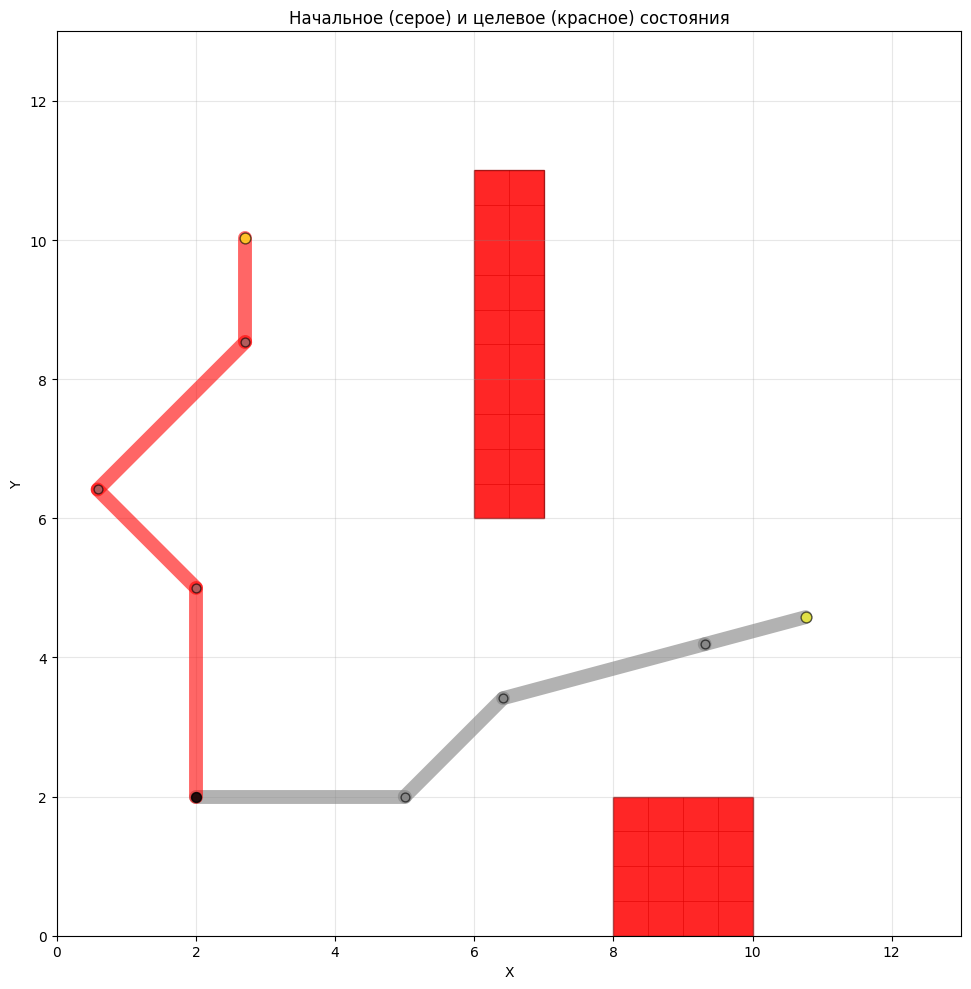

In [10]:
if env.check_manipulator_collision(manipulator, goal_state):
    print("Target state in collision.")

print(
    "Целевое состояние манипулятора:"
    f"[*]Углы суставов: {goal_state.angles}"
    f"[*]Позиция концевика: {manipulator.get_end_effector_position(goal_state)}"
)

viz.setup_plot()
viz.draw_environment()
viz.draw_manipulator(manipulator.state, color='gray', alpha=0.6)
viz.draw_manipulator(goal_state, color='red', alpha=0.6)
plt.title("Начальное (серое) и целевое (красное) состояния")
plt.tight_layout()
plt.show()

2025-12-23 03:15:38.050 | INFO     | __main__:plan:41 - RRT


2025-12-23 03:15:39.326 | INFO     | __main__:plan:77 - 500/20000 итерация, количество нод: 225
2025-12-23 03:15:40.499 | INFO     | __main__:plan:58 - Итерация: 936. Манипулятор в целевом состоянии.
2025-12-23 03:15:40.499 | INFO     | __main__:plan:71 - Алгоритм работал: 2.45 (секунд)
2025-12-23 03:15:40.499 | INFO     | __main__:plan:72 - Длина пути: 20 (состояний)


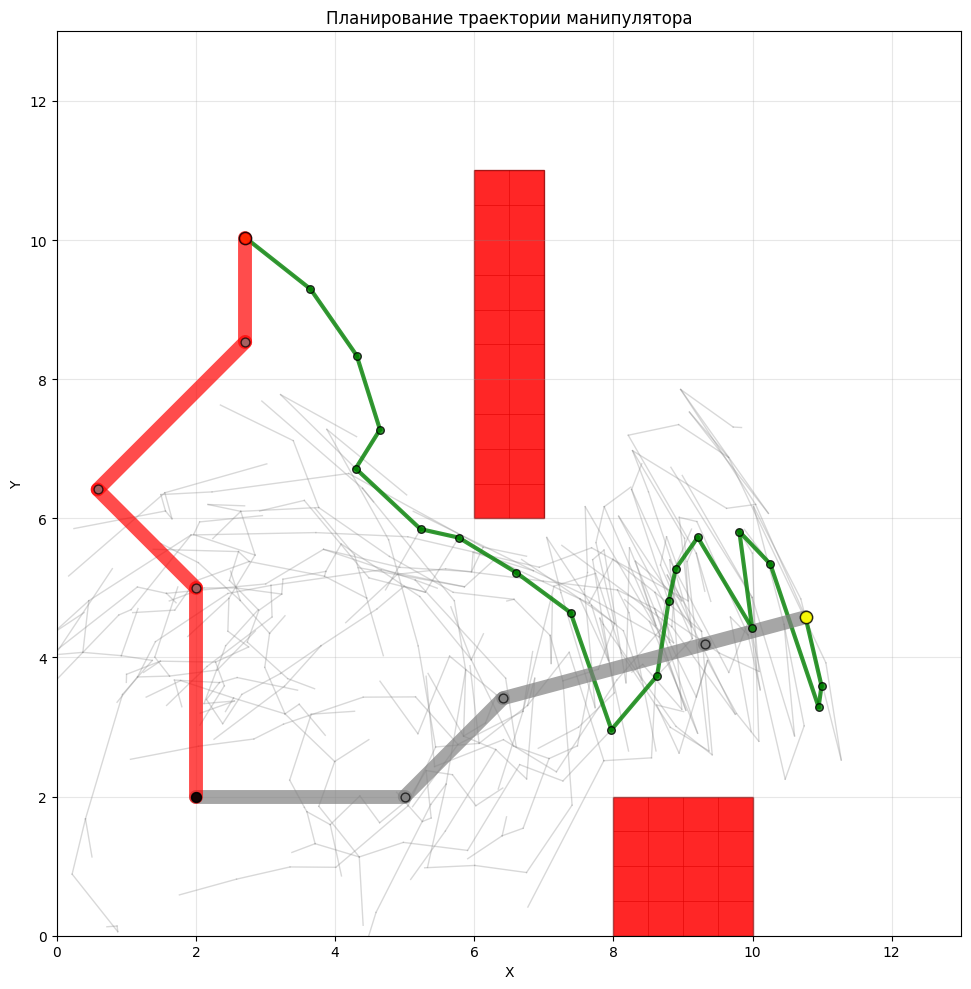

2025-12-23 03:15:41.059 | INFO     | __main__:<module>:15 - Создание анимации движения...


In [11]:
rrt_planner = RRTPlanner(
    manipulator=manipulator,
    environment=env,
    goal_state=goal_state.copy(),
    max_iterations=20000,
    step_size=0.3,
    goal_bias=0.15
)

success, path = rrt_planner.plan()

if success:
    viz.visualize_planning(rrt_planner, path, show_tree=True)
    
    logger.info("Создание анимации движения...")
    anim = viz.animate_path(path, interval=150)
    display(anim)
else:
    logger.warning("RRT планирование не удалось")

2025-12-23 03:15:54.447 | INFO     | __main__:plan:99 - RRT-Connect
2025-12-23 03:15:54.822 | INFO     | __main__:plan:113 - Итерация: 111. Деревья экспансии соеденины.
2025-12-23 03:15:54.822 | INFO     | __main__:plan:126 - Алгоритм работал: 0.37 (секунд)
2025-12-23 03:15:54.822 | INFO     | __main__:plan:127 - Длина пути: 23 (состояний)


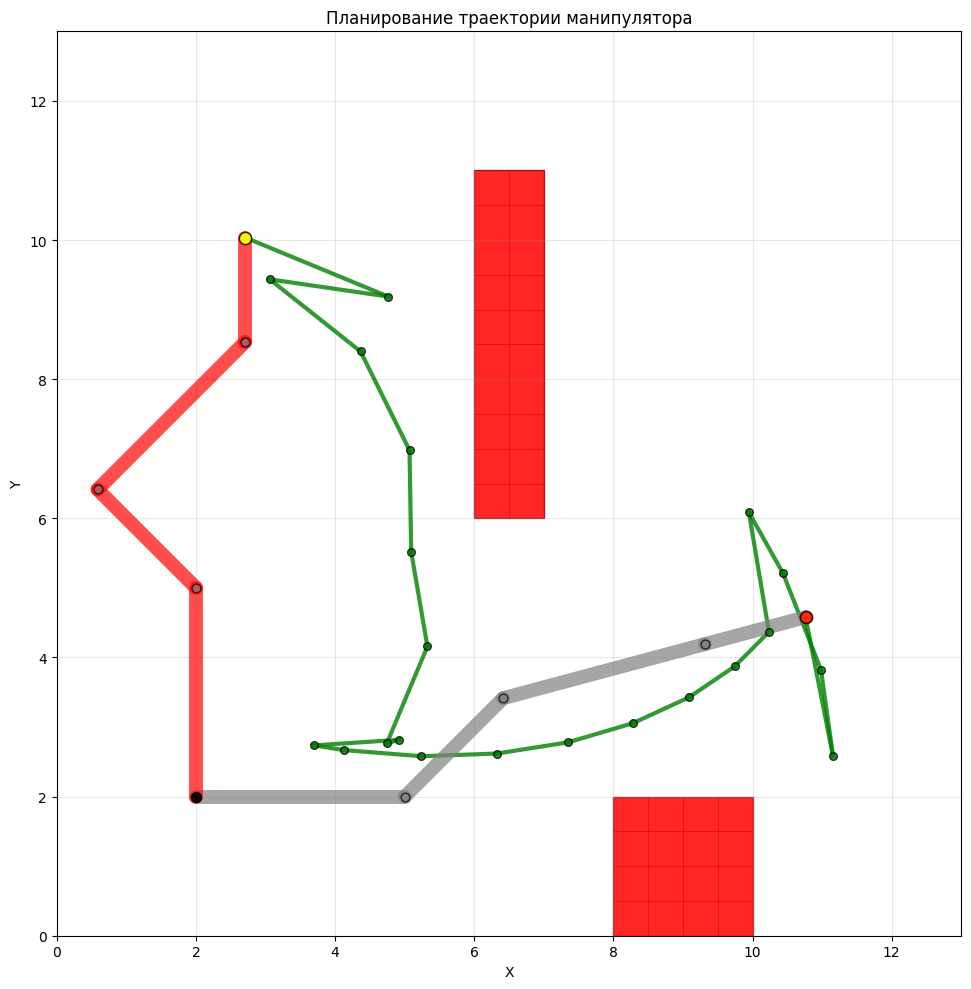

2025-12-23 03:15:55.163 | INFO     | __main__:<module>:15 - Создание анимации движения...


In [12]:
rrt_connect_planner = RRTConnectPlanner(
    manipulator=manipulator,
    environment=env,
    goal_state=goal_state.copy(),
    max_iterations=1500,
    step_size=0.3,
    goal_bias=0.1
)

success, path_connect = rrt_connect_planner.plan()

if success:
    viz.visualize_planning(rrt_connect_planner, path_connect, show_tree=False)
    
    logger.info("Создание анимации движения...")
    anim = viz.animate_path(path_connect, interval=150)
    display(anim)
else:
    logger.warning("RRT планирование не удалось")

## Бенчмаркинг



In [13]:
results: dict[list[dict]] = {
    "rrt_classic": [],
    "rrt_connect": [],
}


for i in range(10):
    logger.info(f"step {i}")
    rrt_planner = RRTPlanner(
        manipulator=manipulator,
        environment=env,
        goal_state=goal_state.copy(),
        max_iterations=20000,
        step_size=0.3,
        goal_bias=0.15
    )

    _, _ = rrt_planner.plan()

    results["rrt_classic"].append(
        rrt_planner.metrics
    )

    rrt_connect_planner = RRTConnectPlanner(
        manipulator=manipulator,
        environment=env,
        goal_state=goal_state.copy(),
        max_iterations=1500,
        step_size=0.3,
        goal_bias=0.1
    )

    _, _ = rrt_connect_planner.plan()

    results["rrt_connect"].append(
        rrt_connect_planner.metrics
    )


2025-12-23 03:16:10.774 | INFO     | __main__:<module>:8 - step 0
2025-12-23 03:16:10.778 | INFO     | __main__:plan:41 - RRT
2025-12-23 03:16:11.867 | INFO     | __main__:plan:77 - 500/20000 итерация, количество нод: 203
2025-12-23 03:16:12.434 | INFO     | __main__:plan:58 - Итерация: 740. Манипулятор в целевом состоянии.
2025-12-23 03:16:12.434 | INFO     | __main__:plan:71 - Алгоритм работал: 1.66 (секунд)
2025-12-23 03:16:12.434 | INFO     | __main__:plan:72 - Длина пути: 24 (состояний)
2025-12-23 03:16:12.442 | INFO     | __main__:plan:99 - RRT-Connect
2025-12-23 03:16:12.684 | INFO     | __main__:plan:113 - Итерация: 79. Деревья экспансии соеденины.
2025-12-23 03:16:12.684 | INFO     | __main__:plan:126 - Алгоритм работал: 0.24 (секунд)
2025-12-23 03:16:12.684 | INFO     | __main__:plan:127 - Длина пути: 28 (состояний)
2025-12-23 03:16:12.690 | INFO     | __main__:<module>:8 - step 1
2025-12-23 03:16:12.692 | INFO     | __main__:plan:41 - RRT
2025-12-23 03:16:13.882 | INFO     |

In [14]:
env.clear_cache()

In [15]:
import pandas as pd

res_df_rrt = pd.DataFrame(results["rrt_classic"])
res_df_rrt_conn = pd.DataFrame(results["rrt_connect"])

In [16]:
pd.DataFrame( [
    {
        "avg_iter": res_df_rrt["n_iterations"].mean(), 
        "avg_nodes":  res_df_rrt["n_nodes"].mean(), 
        "avg_len_path":  res_df_rrt["len_path"].mean(), 
        "avg_time":  res_df_rrt["time"].mean(), 
        "succes_percent":  round(float(res_df_rrt[["is_success"]].sum() / len(res_df_rrt)), 2)
    },
    {
        "avg_iter": res_df_rrt_conn["n_iterations"].mean(), 
        "avg_nodes": np.sum(np.round(np.array([np.array(item) for item in res_df_rrt_conn["n_nodes"]]).mean(axis=0), 2)), 
        "avg_len_path":  res_df_rrt_conn["len_path"].mean(), 
        "avg_time":  res_df_rrt_conn["time"].mean(), 
        "succes_percent":  len(res_df_rrt_conn[res_df_rrt_conn[["is_success"]]]) / len(res_df_rrt_conn)
    },
],
index=["rrt_classic", "rrt_connect"])

,avg_iter,avg_nodes,avg_len_path,avg_time,succes_percent
rrt_classic,5775.7,1766.0,22.3,35.088069,0.9
rrt_connect,152.1,93.4,25.8,0.422005,1.0


# Summary

rrt connection кратно быстрее находит путь до целевого состояния. Приведённые бенчмарки тому доказательство.